<style>
.large-text {
    font-size: 35px;
}
</style>

<span class="large-text">Glitch detection</span>



In [15]:
import torch
import torch.nn as nn
import numpy as np
import os
import random
import shutil
import matplotlib.pyplot as plt
import torchvision
import torch.utils.data as data
import torch.nn.functional as F
import tensorflow as tf
import seaborn 

from torchvision import datasets, transforms
from torchvision.models import ResNet18_Weights, ResNet34_Weights, ResNet50_Weights, ShuffleNet_V2_X1_0_Weights
from torch import optim
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

Split-uieste imaginile din folderul "Complete samples" in 80% train, 10% validation, 10% test.  
  
Imaginile sunt mutate in folderele test, train, val, unde exista si folderele:  
"Normal", "Stretched", "Low", "Placeholder" si "Missing", care ajuta pentru definirea etichetei.  

In [2]:
source_folder = 'Complete samples/Missing'
destination_folder = 'test/Missing'

image_files = [image for image in os.listdir(source_folder)]
print(len(image_files))
selected_images = random.sample(image_files, 50)

for image in selected_images:
    source_path = os.path.join(source_folder, image)
    destination_path = os.path.join(destination_folder, image)
    shutil.move(source_path, destination_path)



KeyboardInterrupt



Aplica data augmentation si formeaza seturile

In [16]:
transform_train = transforms.Compose([
        #transforms.RandomCrop(176),
        #transforms.RandomGrayscale(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAdjustSharpness(2, p=0.2),
        transforms.RandomRotation(45),
        #transforms.RandomInvert(),
        transforms.ToTensor(),
        transforms.Normalize(mean=0, std=1)
    ])

transform_validation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=0, std=1)
    ])

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=0, std=1)
    ])

train_set = datasets.ImageFolder(root='train', transform=transform_train)
validation_set = datasets.ImageFolder(root='val', transform=transform_validation)
test_set = datasets.ImageFolder(root='test', transform=transform_test)


Acomodare cu setul de date.

In [17]:
print("Length of sets (num_images * num_classes):")
print("Train set length:", len(train_set))
print("Validation set length:", len(validation_set))
print("Test set length:", len(test_set))

Length of sets (num_images * num_classes):
Train set length: 2000
Validation set length: 250
Test set length: 250


In [18]:
train_image = np.array(train_set[0][0])
validation_image = np.array(validation_set[0][0])
test_image = np.array(test_set[0][0])

print("Train Set Shape:", train_image.shape) 
print("Validation Set Shape:", validation_image.shape)  
print("Test Set Shape:", test_image.shape)  

Train Set Shape: (3, 224, 224)
Validation Set Shape: (3, 224, 224)
Test Set Shape: (3, 224, 224)


In [19]:
classes = train_set.classes
print("All classes:", classes)

All classes: ['Low', 'Missing', 'Normal', 'Placeholder', 'Stretched']


Afisarea unui exemplu aleator din set.

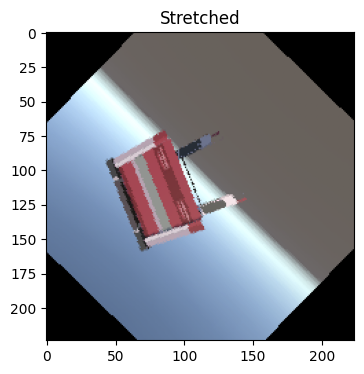

In [22]:
image, label = train_set[random.randint(0, len(train_set)-1)]

image = np.array(image)
image = np.transpose(image, (1, 2, 0))
plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.title(train_set.classes[label])
plt.show()

Modelul foloseste resursele din GPU.

In [23]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
tf.config.list_physical_devices('GPU')
print("Running on " + device.type)

Running on cuda


Definirea unor parametrii si a networkului.  
Variabilele de tip x_nume sunt folosite pentru salvarea rezultatelor.

In [24]:
epochs = 100

net = torchvision.models.shufflenet_v2_x1_0(weights=ShuffleNet_V2_X1_0_Weights.DEFAULT)
net_name = "ShuffleNetV2"
pretrained_name = "Pretrained"

num_features = net.fc.in_features
net.fc = nn.Sequential(
    nn.Dropout(0.5), 
    nn.Linear(num_features, 5)
)

net = net.to(device)

optimizer = optim.Adam(net.parameters(), lr=1e-4)
optimizer_name = "Adam"
lr_name = "10^-4"
optimizer.zero_grad()

loss_fn = nn.CrossEntropyLoss()
loss_fn_name = "CrossEntropy"

Impartim datele in batchuri.

In [25]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=8, shuffle=True)

Optional: Incarca un model deja antrenat


In [44]:
path = "model\model_100_ShuffleNetv2_b8_Pretrained_Adam_10^-4_CrossEntropy.pth"
checkpoint = torch.load(path)
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
saved_epoch = checkpoint['epoch']
loss = checkpoint['loss']

Calculul pentru loss si accuracy.  
Ultima epoca parcursa si cea mai buna epoca sunt salvate local.  
Sunt afisate grafice cu loss si accuracy.

In [26]:
saved_epoch = -1
def train_fn(epochs: int, train_loader: data.DataLoader, validation_loader: data.DataLoader, 
net: nn.Module, loss_fn: nn.Module, optimizer: optim.Optimizer):

  max_validation_acc = -1
  train_losses = []
  validation_losses = []
  train_accuracies = []
  validation_accuracies = []

#Continue from saved epoch
  for epoch in range(saved_epoch + 1, saved_epoch + epochs + 1):
    epoch_train_loss = 0
    epoch_train_acc = 0

    #Calculate train values
    net.train()

    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        correct_labels = 0
        total_labels = 0

        #Get correct predicted labels for train
        for j, output in enumerate(outputs):
            sm_output = F.softmax(output, dim=0)
            label = torch.argmax(sm_output)
            if labels[j] == label:
                correct_labels += 1
            total_labels += 1

        loss = loss_fn(outputs, labels)
        epoch_train_loss += loss.item()
        train_acc = correct_labels / total_labels
        epoch_train_acc += train_acc
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    #Calculate validation values
    net.eval()
    
    with torch.no_grad():
        epoch_val_loss = 0
        epoch_val_acc = 0
        for images, labels in tqdm(validation_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            correct_labels = 0
            total_labels = 0

            #Get correct predicted labels for validation
            for j, output in enumerate(outputs):
                sm_output = F.softmax(output, dim=0)
                label = torch.argmax(sm_output)
                if labels[j] == label:
                    correct_labels += 1
                total_labels += 1
            
            #Add results to loss and accuracy
            validation_loss = loss_fn(outputs, labels)
            epoch_val_loss += validation_loss.item()
            validation_acc = correct_labels / total_labels
            epoch_val_acc += validation_acc

    #Calculate losses and accuracies
    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_train_acc = epoch_train_acc / len(train_loader)
    avg_val_loss = epoch_val_loss / len(validation_loader)
    avg_val_acc = epoch_val_acc / len(validation_loader)

    #Saved best epoch based on validation accuracy
    if avg_val_acc >= max_validation_acc:
        max_validation_acc = avg_val_acc

        torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'validation_loss': avg_val_loss,
            'train_accuracy': avg_train_acc,
            'validation_accuracy:': avg_val_acc,
        }, f"model/best_epoch_{net_name}_{pretrained_name}_{optimizer_name}_{lr_name}_{loss_fn_name}.pth")

    #Save last epoch
    if epoch == saved_epoch + epochs:
        torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_train_loss,
        }, f'./model/model_{epoch+1}_{net_name}_{pretrained_name}_{optimizer_name}_{lr_name}_{loss_fn_name}.pth')

    #Add results to list for plotting
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)
    validation_losses.append(avg_val_loss)
    validation_accuracies.append(avg_val_acc)

    #Print current epoch results
    print(f'Epoch {epoch+1}/{saved_epoch + epochs+1} Train loss: {avg_train_loss:.4f}, Validation loss:{avg_val_loss:.4f}, Train accuracy: {avg_train_acc:.4f}, Validation accuracy: {avg_val_acc:.4f}')

  #Plot and save loss  
  plt.figure(figsize=(10, 5))
  plt.title("Training and Validation Loss")
  plt.plot(validation_losses, label="validation")
  plt.plot(train_losses, label="train")
  plt.xlabel("epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.savefig(f"./loss_and_acc/loss_plot_{epoch+1}_{net_name}_{pretrained_name}_{optimizer_name}_{lr_name}_{loss_fn_name}.png")
  plt.show()

  #Plot and save accuracies
  plt.figure(figsize=(10, 5))
  plt.title("Training and Validation Accuracy")
  plt.plot(validation_accuracies, label="validation")
  plt.plot(train_accuracies, label="train")
  plt.xlabel("epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.savefig(f"./loss_and_acc/accuracy_plot_{epoch+1}_{net_name}_{pretrained_name}_{optimizer_name}_{lr_name}_{loss_fn_name}.png")
  plt.show()

100%|██████████| 32/32 [00:02<00:00, 11.83it/s]


Epoch 1/100 Train loss: 1.4291, Validation loss:0.9953, Train accuracy: 0.4965, Validation accuracy: 0.6172


100%|██████████| 32/32 [00:01<00:00, 26.36it/s]


Epoch 2/100 Train loss: 0.9746, Validation loss:0.7503, Train accuracy: 0.5985, Validation accuracy: 0.6406


100%|██████████| 32/32 [00:01<00:00, 27.19it/s]


Epoch 3/100 Train loss: 0.8198, Validation loss:0.6806, Train accuracy: 0.6360, Validation accuracy: 0.7070


100%|██████████| 32/32 [00:01<00:00, 16.79it/s]


Epoch 4/100 Train loss: 0.7223, Validation loss:0.5827, Train accuracy: 0.6745, Validation accuracy: 0.7383


100%|██████████| 32/32 [00:01<00:00, 28.07it/s]


Epoch 5/100 Train loss: 0.6678, Validation loss:0.5503, Train accuracy: 0.7135, Validation accuracy: 0.7812


100%|██████████| 32/32 [00:01<00:00, 27.28it/s]


Epoch 6/100 Train loss: 0.5900, Validation loss:0.4423, Train accuracy: 0.7405, Validation accuracy: 0.8242


100%|██████████| 32/32 [00:01<00:00, 30.70it/s]


Epoch 7/100 Train loss: 0.5278, Validation loss:0.3824, Train accuracy: 0.7790, Validation accuracy: 0.8438


100%|██████████| 32/32 [00:01<00:00, 27.56it/s]


Epoch 8/100 Train loss: 0.4746, Validation loss:0.3252, Train accuracy: 0.8095, Validation accuracy: 0.8945


100%|██████████| 32/32 [00:01<00:00, 31.36it/s]


Epoch 9/100 Train loss: 0.4419, Validation loss:0.2778, Train accuracy: 0.8220, Validation accuracy: 0.8984


100%|██████████| 32/32 [00:01<00:00, 27.76it/s]


Epoch 10/100 Train loss: 0.4018, Validation loss:0.2368, Train accuracy: 0.8475, Validation accuracy: 0.9062


100%|██████████| 32/32 [00:00<00:00, 32.41it/s]


Epoch 11/100 Train loss: 0.3530, Validation loss:0.2200, Train accuracy: 0.8660, Validation accuracy: 0.9336


100%|██████████| 32/32 [00:01<00:00, 27.73it/s]


Epoch 12/100 Train loss: 0.3118, Validation loss:0.1742, Train accuracy: 0.8865, Validation accuracy: 0.9375


100%|██████████| 32/32 [00:01<00:00, 23.35it/s]


Epoch 13/100 Train loss: 0.2834, Validation loss:0.1810, Train accuracy: 0.8980, Validation accuracy: 0.9492


100%|██████████| 32/32 [00:01<00:00, 30.73it/s]


Epoch 14/100 Train loss: 0.2605, Validation loss:0.1730, Train accuracy: 0.9080, Validation accuracy: 0.9375


100%|██████████| 32/32 [00:01<00:00, 27.26it/s]


Epoch 15/100 Train loss: 0.2605, Validation loss:0.1602, Train accuracy: 0.9010, Validation accuracy: 0.9336


100%|██████████| 32/32 [00:01<00:00, 27.76it/s]


Epoch 16/100 Train loss: 0.2370, Validation loss:0.1514, Train accuracy: 0.9100, Validation accuracy: 0.9453


100%|██████████| 32/32 [00:00<00:00, 32.77it/s]


Epoch 17/100 Train loss: 0.2024, Validation loss:0.1627, Train accuracy: 0.9270, Validation accuracy: 0.9336


100%|██████████| 32/32 [00:00<00:00, 32.84it/s]


Epoch 18/100 Train loss: 0.1927, Validation loss:0.1142, Train accuracy: 0.9370, Validation accuracy: 0.9531


100%|██████████| 32/32 [00:00<00:00, 32.64it/s]


Epoch 19/100 Train loss: 0.1976, Validation loss:0.1212, Train accuracy: 0.9280, Validation accuracy: 0.9453


100%|██████████| 32/32 [00:00<00:00, 32.81it/s]


Epoch 20/100 Train loss: 0.1767, Validation loss:0.1131, Train accuracy: 0.9320, Validation accuracy: 0.9609


100%|██████████| 32/32 [00:00<00:00, 32.84it/s]


Epoch 21/100 Train loss: 0.1729, Validation loss:0.1129, Train accuracy: 0.9370, Validation accuracy: 0.9453


100%|██████████| 32/32 [00:00<00:00, 32.74it/s]


Epoch 22/100 Train loss: 0.1646, Validation loss:0.1148, Train accuracy: 0.9435, Validation accuracy: 0.9570


100%|██████████| 32/32 [00:00<00:00, 32.74it/s]


Epoch 23/100 Train loss: 0.1487, Validation loss:0.0951, Train accuracy: 0.9470, Validation accuracy: 0.9570


100%|██████████| 32/32 [00:00<00:00, 32.91it/s]


Epoch 24/100 Train loss: 0.1493, Validation loss:0.1395, Train accuracy: 0.9460, Validation accuracy: 0.9414


100%|██████████| 32/32 [00:00<00:00, 32.28it/s]


Epoch 25/100 Train loss: 0.1453, Validation loss:0.1214, Train accuracy: 0.9495, Validation accuracy: 0.9648


100%|██████████| 32/32 [00:01<00:00, 30.67it/s]


Epoch 26/100 Train loss: 0.1465, Validation loss:0.1039, Train accuracy: 0.9470, Validation accuracy: 0.9609


100%|██████████| 32/32 [00:01<00:00, 31.12it/s]


Epoch 27/100 Train loss: 0.1131, Validation loss:0.1075, Train accuracy: 0.9605, Validation accuracy: 0.9453


100%|██████████| 32/32 [00:00<00:00, 32.21it/s]


Epoch 28/100 Train loss: 0.1283, Validation loss:0.0972, Train accuracy: 0.9530, Validation accuracy: 0.9609


100%|██████████| 32/32 [00:00<00:00, 32.38it/s]


Epoch 29/100 Train loss: 0.1178, Validation loss:0.0783, Train accuracy: 0.9565, Validation accuracy: 0.9766


100%|██████████| 32/32 [00:00<00:00, 32.38it/s]


Epoch 30/100 Train loss: 0.1142, Validation loss:0.1320, Train accuracy: 0.9580, Validation accuracy: 0.9492


100%|██████████| 32/32 [00:00<00:00, 32.25it/s]


Epoch 31/100 Train loss: 0.1204, Validation loss:0.1060, Train accuracy: 0.9585, Validation accuracy: 0.9492


100%|██████████| 32/32 [00:00<00:00, 32.41it/s]


Epoch 32/100 Train loss: 0.1088, Validation loss:0.1253, Train accuracy: 0.9615, Validation accuracy: 0.9492


100%|██████████| 32/32 [00:00<00:00, 32.38it/s]


Epoch 33/100 Train loss: 0.1088, Validation loss:0.0910, Train accuracy: 0.9620, Validation accuracy: 0.9609


100%|██████████| 32/32 [00:00<00:00, 32.48it/s]


Epoch 34/100 Train loss: 0.0947, Validation loss:0.0748, Train accuracy: 0.9620, Validation accuracy: 0.9688


100%|██████████| 32/32 [00:00<00:00, 32.34it/s]


Epoch 35/100 Train loss: 0.1023, Validation loss:0.0867, Train accuracy: 0.9615, Validation accuracy: 0.9531


100%|██████████| 32/32 [00:00<00:00, 32.25it/s]


Epoch 36/100 Train loss: 0.0837, Validation loss:0.0677, Train accuracy: 0.9700, Validation accuracy: 0.9727


100%|██████████| 32/32 [00:00<00:00, 32.44it/s]


Epoch 37/100 Train loss: 0.0855, Validation loss:0.0773, Train accuracy: 0.9680, Validation accuracy: 0.9727


100%|██████████| 32/32 [00:00<00:00, 32.21it/s]


Epoch 38/100 Train loss: 0.0983, Validation loss:0.0762, Train accuracy: 0.9650, Validation accuracy: 0.9727


100%|██████████| 32/32 [00:00<00:00, 32.25it/s]


Epoch 39/100 Train loss: 0.0769, Validation loss:0.0585, Train accuracy: 0.9750, Validation accuracy: 0.9805


100%|██████████| 32/32 [00:00<00:00, 32.41it/s]


Epoch 40/100 Train loss: 0.0720, Validation loss:0.0996, Train accuracy: 0.9710, Validation accuracy: 0.9453


100%|██████████| 32/32 [00:01<00:00, 31.89it/s]


Epoch 41/100 Train loss: 0.0771, Validation loss:0.0775, Train accuracy: 0.9740, Validation accuracy: 0.9648


100%|██████████| 32/32 [00:01<00:00, 31.03it/s]


Epoch 42/100 Train loss: 0.0723, Validation loss:0.0658, Train accuracy: 0.9755, Validation accuracy: 0.9688


100%|██████████| 32/32 [00:00<00:00, 32.09it/s]


Epoch 43/100 Train loss: 0.0651, Validation loss:0.1252, Train accuracy: 0.9765, Validation accuracy: 0.9648


100%|██████████| 32/32 [00:00<00:00, 32.67it/s]


Epoch 44/100 Train loss: 0.0725, Validation loss:0.0839, Train accuracy: 0.9740, Validation accuracy: 0.9648


100%|██████████| 32/32 [00:00<00:00, 32.54it/s]


Epoch 45/100 Train loss: 0.0644, Validation loss:0.0861, Train accuracy: 0.9755, Validation accuracy: 0.9648


100%|██████████| 32/32 [00:00<00:00, 32.54it/s]


Epoch 46/100 Train loss: 0.0703, Validation loss:0.0616, Train accuracy: 0.9725, Validation accuracy: 0.9688


100%|██████████| 32/32 [00:00<00:00, 32.15it/s]


Epoch 47/100 Train loss: 0.0668, Validation loss:0.1105, Train accuracy: 0.9780, Validation accuracy: 0.9609


100%|██████████| 32/32 [00:01<00:00, 31.89it/s]


Epoch 48/100 Train loss: 0.0677, Validation loss:0.0741, Train accuracy: 0.9760, Validation accuracy: 0.9688


100%|██████████| 32/32 [00:01<00:00, 30.47it/s]


Epoch 49/100 Train loss: 0.0595, Validation loss:0.0839, Train accuracy: 0.9815, Validation accuracy: 0.9609


100%|██████████| 32/32 [00:01<00:00, 30.59it/s]


Epoch 50/100 Train loss: 0.0739, Validation loss:0.0658, Train accuracy: 0.9710, Validation accuracy: 0.9766


100%|██████████| 32/32 [00:01<00:00, 31.89it/s]


Epoch 51/100 Train loss: 0.0527, Validation loss:0.0490, Train accuracy: 0.9785, Validation accuracy: 0.9844


100%|██████████| 32/32 [00:01<00:00, 30.88it/s]


Epoch 52/100 Train loss: 0.0577, Validation loss:0.0935, Train accuracy: 0.9790, Validation accuracy: 0.9570


100%|██████████| 32/32 [00:01<00:00, 30.21it/s]


Epoch 53/100 Train loss: 0.0531, Validation loss:0.0589, Train accuracy: 0.9795, Validation accuracy: 0.9766


100%|██████████| 32/32 [00:00<00:00, 32.05it/s]


Epoch 54/100 Train loss: 0.0662, Validation loss:0.0524, Train accuracy: 0.9750, Validation accuracy: 0.9805


100%|██████████| 32/32 [00:01<00:00, 30.67it/s]


Epoch 55/100 Train loss: 0.0622, Validation loss:0.0519, Train accuracy: 0.9790, Validation accuracy: 0.9766


100%|██████████| 32/32 [00:00<00:00, 32.38it/s]


Epoch 56/100 Train loss: 0.0546, Validation loss:0.0523, Train accuracy: 0.9810, Validation accuracy: 0.9766


100%|██████████| 32/32 [00:00<00:00, 32.28it/s]


Epoch 57/100 Train loss: 0.0520, Validation loss:0.0867, Train accuracy: 0.9835, Validation accuracy: 0.9648


100%|██████████| 32/32 [00:00<00:00, 32.15it/s]


Epoch 58/100 Train loss: 0.0411, Validation loss:0.0649, Train accuracy: 0.9855, Validation accuracy: 0.9766


100%|██████████| 32/32 [00:01<00:00, 30.10it/s]


Epoch 59/100 Train loss: 0.0547, Validation loss:0.0557, Train accuracy: 0.9785, Validation accuracy: 0.9727


100%|██████████| 32/32 [00:00<00:00, 32.34it/s]


Epoch 60/100 Train loss: 0.0494, Validation loss:0.0479, Train accuracy: 0.9825, Validation accuracy: 0.9766


100%|██████████| 32/32 [00:01<00:00, 31.00it/s]


Epoch 61/100 Train loss: 0.0579, Validation loss:0.0680, Train accuracy: 0.9825, Validation accuracy: 0.9727


100%|██████████| 32/32 [00:00<00:00, 32.09it/s]


Epoch 62/100 Train loss: 0.0621, Validation loss:0.0918, Train accuracy: 0.9800, Validation accuracy: 0.9688


100%|██████████| 32/32 [00:01<00:00, 30.62it/s]


Epoch 63/100 Train loss: 0.0311, Validation loss:0.0771, Train accuracy: 0.9885, Validation accuracy: 0.9766


100%|██████████| 32/32 [00:00<00:00, 32.15it/s]


Epoch 64/100 Train loss: 0.0503, Validation loss:0.0741, Train accuracy: 0.9825, Validation accuracy: 0.9727


100%|██████████| 32/32 [00:01<00:00, 28.83it/s]


Epoch 65/100 Train loss: 0.0473, Validation loss:0.0720, Train accuracy: 0.9840, Validation accuracy: 0.9727


100%|██████████| 32/32 [00:01<00:00, 31.89it/s]


Epoch 66/100 Train loss: 0.0560, Validation loss:0.0900, Train accuracy: 0.9815, Validation accuracy: 0.9609


100%|██████████| 32/32 [00:00<00:00, 32.09it/s]


Epoch 67/100 Train loss: 0.0322, Validation loss:0.0801, Train accuracy: 0.9885, Validation accuracy: 0.9609


100%|██████████| 32/32 [00:00<00:00, 32.12it/s]


Epoch 68/100 Train loss: 0.0427, Validation loss:0.0526, Train accuracy: 0.9860, Validation accuracy: 0.9805


100%|██████████| 32/32 [00:01<00:00, 31.93it/s]


Epoch 69/100 Train loss: 0.0428, Validation loss:0.0507, Train accuracy: 0.9845, Validation accuracy: 0.9727


100%|██████████| 32/32 [00:01<00:00, 31.89it/s]


Epoch 70/100 Train loss: 0.0435, Validation loss:0.0464, Train accuracy: 0.9845, Validation accuracy: 0.9805


100%|██████████| 32/32 [00:01<00:00, 31.80it/s]


Epoch 71/100 Train loss: 0.0398, Validation loss:0.0725, Train accuracy: 0.9870, Validation accuracy: 0.9727


100%|██████████| 32/32 [00:00<00:00, 32.28it/s]


Epoch 72/100 Train loss: 0.0387, Validation loss:0.0673, Train accuracy: 0.9880, Validation accuracy: 0.9766


100%|██████████| 32/32 [00:01<00:00, 29.41it/s]


Epoch 73/100 Train loss: 0.0428, Validation loss:0.0562, Train accuracy: 0.9835, Validation accuracy: 0.9805


100%|██████████| 32/32 [00:01<00:00, 30.47it/s]


Epoch 74/100 Train loss: 0.0595, Validation loss:0.0755, Train accuracy: 0.9800, Validation accuracy: 0.9766


100%|██████████| 32/32 [00:01<00:00, 31.86it/s]


Epoch 75/100 Train loss: 0.0432, Validation loss:0.0555, Train accuracy: 0.9815, Validation accuracy: 0.9805


100%|██████████| 32/32 [00:01<00:00, 31.77it/s]


Epoch 76/100 Train loss: 0.0317, Validation loss:0.0611, Train accuracy: 0.9900, Validation accuracy: 0.9727


100%|██████████| 32/32 [00:01<00:00, 31.74it/s]


Epoch 77/100 Train loss: 0.0351, Validation loss:0.0510, Train accuracy: 0.9875, Validation accuracy: 0.9805


100%|██████████| 32/32 [00:01<00:00, 31.93it/s]


Epoch 78/100 Train loss: 0.0334, Validation loss:0.0460, Train accuracy: 0.9865, Validation accuracy: 0.9844


100%|██████████| 32/32 [00:01<00:00, 31.93it/s]


Epoch 79/100 Train loss: 0.0437, Validation loss:0.0471, Train accuracy: 0.9855, Validation accuracy: 0.9844


100%|██████████| 32/32 [00:01<00:00, 31.93it/s]


Epoch 80/100 Train loss: 0.0382, Validation loss:0.0836, Train accuracy: 0.9860, Validation accuracy: 0.9688


100%|██████████| 32/32 [00:01<00:00, 31.36it/s]


Epoch 81/100 Train loss: 0.0384, Validation loss:0.0662, Train accuracy: 0.9850, Validation accuracy: 0.9844


100%|██████████| 32/32 [00:01<00:00, 31.86it/s]


Epoch 82/100 Train loss: 0.0380, Validation loss:0.0612, Train accuracy: 0.9890, Validation accuracy: 0.9844


100%|██████████| 32/32 [00:01<00:00, 31.58it/s]


Epoch 83/100 Train loss: 0.0382, Validation loss:0.0515, Train accuracy: 0.9880, Validation accuracy: 0.9844


100%|██████████| 32/32 [00:01<00:00, 31.61it/s]


Epoch 84/100 Train loss: 0.0224, Validation loss:0.0409, Train accuracy: 0.9915, Validation accuracy: 0.9922


100%|██████████| 32/32 [00:01<00:00, 31.58it/s]


Epoch 85/100 Train loss: 0.0387, Validation loss:0.1059, Train accuracy: 0.9845, Validation accuracy: 0.9766


100%|██████████| 32/32 [00:01<00:00, 31.93it/s]


Epoch 86/100 Train loss: 0.0332, Validation loss:0.0632, Train accuracy: 0.9875, Validation accuracy: 0.9805


100%|██████████| 32/32 [00:01<00:00, 31.58it/s]


Epoch 87/100 Train loss: 0.0364, Validation loss:0.0658, Train accuracy: 0.9870, Validation accuracy: 0.9844


100%|██████████| 32/32 [00:01<00:00, 31.64it/s]


Epoch 88/100 Train loss: 0.0333, Validation loss:0.0931, Train accuracy: 0.9875, Validation accuracy: 0.9766


100%|██████████| 32/32 [00:01<00:00, 31.71it/s]


Epoch 89/100 Train loss: 0.0387, Validation loss:0.0844, Train accuracy: 0.9870, Validation accuracy: 0.9688


100%|██████████| 32/32 [00:01<00:00, 31.71it/s]


Epoch 90/100 Train loss: 0.0343, Validation loss:0.0674, Train accuracy: 0.9875, Validation accuracy: 0.9844


100%|██████████| 32/32 [00:01<00:00, 31.77it/s]


Epoch 91/100 Train loss: 0.0441, Validation loss:0.0494, Train accuracy: 0.9845, Validation accuracy: 0.9883


100%|██████████| 32/32 [00:01<00:00, 31.74it/s]


Epoch 92/100 Train loss: 0.0312, Validation loss:0.0804, Train accuracy: 0.9890, Validation accuracy: 0.9805


100%|██████████| 32/32 [00:01<00:00, 31.74it/s]


Epoch 93/100 Train loss: 0.0427, Validation loss:0.0590, Train accuracy: 0.9875, Validation accuracy: 0.9766


100%|██████████| 32/32 [00:01<00:00, 31.61it/s]


Epoch 94/100 Train loss: 0.0289, Validation loss:0.0464, Train accuracy: 0.9900, Validation accuracy: 0.9883


100%|██████████| 32/32 [00:01<00:00, 31.83it/s]


Epoch 95/100 Train loss: 0.0246, Validation loss:0.0849, Train accuracy: 0.9945, Validation accuracy: 0.9648


100%|██████████| 32/32 [00:01<00:00, 31.67it/s]


Epoch 96/100 Train loss: 0.0301, Validation loss:0.0653, Train accuracy: 0.9890, Validation accuracy: 0.9766


100%|██████████| 32/32 [00:01<00:00, 31.46it/s]


Epoch 97/100 Train loss: 0.0251, Validation loss:0.0681, Train accuracy: 0.9930, Validation accuracy: 0.9727


100%|██████████| 32/32 [00:01<00:00, 23.13it/s]


Epoch 98/100 Train loss: 0.0371, Validation loss:0.0754, Train accuracy: 0.9865, Validation accuracy: 0.9805


100%|██████████| 32/32 [00:01<00:00, 31.36it/s]


Epoch 99/100 Train loss: 0.0275, Validation loss:0.0680, Train accuracy: 0.9915, Validation accuracy: 0.9766


100%|██████████| 32/32 [00:01<00:00, 31.67it/s]


Epoch 100/100 Train loss: 0.0235, Validation loss:0.0798, Train accuracy: 0.9915, Validation accuracy: 0.9805


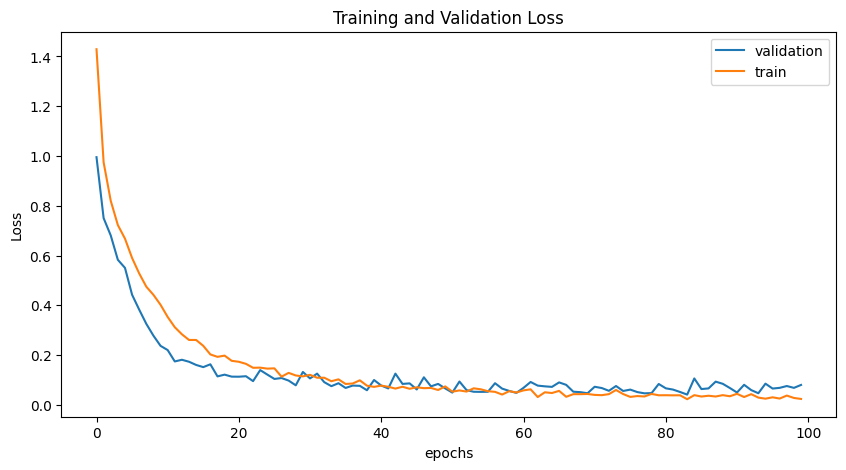

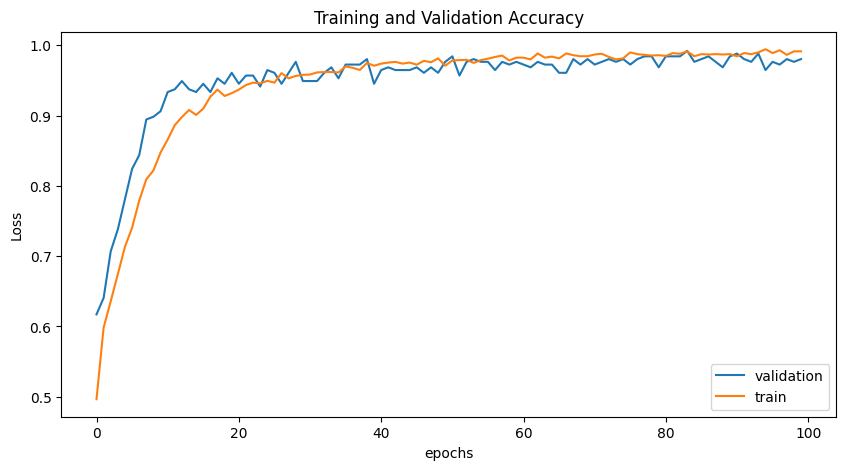

In [27]:
train_fn(epochs, train_loader, test_loader, net, loss_fn, optimizer)

Testarea modelului.  
Calulul pentru precision si recall.

In [28]:
net.eval()

correct_labels = 0
total_labels = 0

Tp_normal = Fp_normal = Fn_normal = 0
Tp_low = Fp_low = Fn_low = 0
Tp_stretched = Fp_stretched = Fn_stretched = 0
Tp_missing = Fp_missing = Fn_missing = 0
Tp_placeholder = Fp_placeholder = Fn_placeholder = 0

for images, labels in tqdm(test_loader):
    images = images.to(device)
    labels = labels.to(device)

    outputs = net(images)
    
    for j, output in enumerate(outputs):

        sm_output = F.softmax(output, dim=0)
        label = torch.argmax(sm_output)
        
        if labels[j] == label:
            correct_labels += 1
        total_labels += 1
        #Calculate True Positive
        if labels[j] == label:
            if labels[j] == 0:
                Tp_low += 1
            if labels[j] == 1:
                Tp_missing += 1
            if labels[j] == 2:
                Tp_normal += 1
            if labels[j] == 3:
                Tp_placeholder += 1
            if labels[j] == 4:
                Tp_stretched += 1

        #Calculate False Positive and False Negative        
        else:
            if label == 0:
                Fp_low += 1
            if label == 1:
                Fp_missing += 1
            if label == 2:
                Fp_normal += 1
            if label == 3:
                Fp_placeholder += 1
            if label == 4:
                Fp_stretched += 1
                    
            if labels[j] == 0:
                Fn_low += 1
            if labels[j] == 1:
                Fn_missing += 1
            if labels[j] == 2:
                Fn_normal += 1
            if labels[j] == 3:
                Fn_placeholder += 1
            if labels[j] == 4:
                Fn_stretched += 1
    
#Calculate precision
precision_low = round(Tp_low / (Tp_low + Fp_low), 4)
precision_missing = round(Tp_missing / (Tp_missing + Fp_missing), 4)
precision_normal = round(Tp_normal / (Tp_normal + Fp_normal), 4)
precision_placeholder = round(Tp_placeholder / (Tp_placeholder + Fp_placeholder), 4)
precision_stretched = round(Tp_stretched / (Tp_stretched + Fp_stretched), 4)

#Calculate recall
recall_low = round(Tp_low / (Tp_low + Fn_low), 4)
recall_missing = round(Tp_missing / (Tp_missing + Fn_missing), 4)
recall_normal = round(Tp_normal / (Tp_normal + Fn_normal), 4)
recall_placeholder = round(Tp_placeholder / (Tp_placeholder + Fn_placeholder), 4)
recall_stretched = round(Tp_stretched / (Tp_stretched + Fn_stretched), 4)

print(f'Precision_low: {precision_low}, Precision_missing: {precision_missing}, Precision_normal: {precision_normal}, Precision_placeholder: {precision_placeholder}, Precision_stretched: {precision_stretched}')
print(f'Recall_low: {recall_low}, Recall_missing: {recall_missing}, Recall_normal: {recall_normal}, Recall_placeholder: {recall_placeholder}, Recall_stretched: {recall_stretched}')
        

test_acc = correct_labels / total_labels
print(f'Test accuracy: {test_acc:.4f}')

100%|██████████| 32/32 [00:01<00:00, 22.13it/s]

Precision_low: 0.9792, Precision_missing: 1.0, Precision_normal: 0.9259, Precision_placeholder: 1.0, Precision_stretched: 1.0
Recall_low: 0.94, Recall_missing: 1.0, Recall_normal: 1.0, Recall_placeholder: 1.0, Recall_stretched: 0.96
Test accuracy: 0.9800


Optional: Afiseza valorile pentru cea mai buna epoca. Folositor pentru extragerea rezultatelor

In [29]:
path = "model/best_epoch_ShuffleNetV2_b8_Pretrained_Adam_10^-4_CrossEntropy.pth"
checkpoint = torch.load(path)
best_epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
validation_loss = checkpoint['validation_loss']
train_accuracy = checkpoint['train_accuracy']
validation_accuracy = checkpoint['validation_accuracy:']

print(f"Best epoch: {best_epoch}, Train loss: {train_loss}, Validation loss: {validation_loss}, Train accuracy: {train_accuracy}, Validation accuracy: {validation_accuracy}")


Best epoch: 86, Train loss: 0.037849855808657594, Validation loss: 0.035061252765444806, Train accuracy: 0.9855, Validation accuracy: 0.9921875


Matricea de confuzie pentru train, val, test si salvarea lor in memorie.

In [30]:
def plot_cm(matrix, set_type, numeric_type):
    plt.figure(figsize=(10,10))
    ax = plt.subplot()
    seaborn.heatmap(matrix, annot=True, fmt='g', ax=ax)

    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(f'Confusion Matrix for {set_type}')

    ax.xaxis.set_ticklabels(classes)
    ax.yaxis.set_ticklabels(classes)

    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    
    plt.savefig(f"./conf_matrices/{set_type} matrix_{numeric_type}_{net_name}_{pretrained_name}_{optimizer_name}_{lr_name}_{loss_fn_name}.png")
    plt.show()

In [31]:
def get_cm(loader, set_type="train"):
    predicted_labels = []
    correct_labels = []

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images)

        for j, output in enumerate(outputs):
            sm_output = F.softmax(output, dim=0)
            label = torch.argmax(sm_output)

            correct_label = labels[j].cpu().detach().numpy()
            predicted_label = label.cpu().detach().numpy()
            predicted_labels.append(predicted_label)
            correct_labels.append(correct_label)

    cm = confusion_matrix(predicted_labels, correct_labels)
    plot_cm(cm, set_type, "number")
    
    cmn = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
    cmn = 100 * cmn
    plot_cm(cmn, set_type, 'percentage')


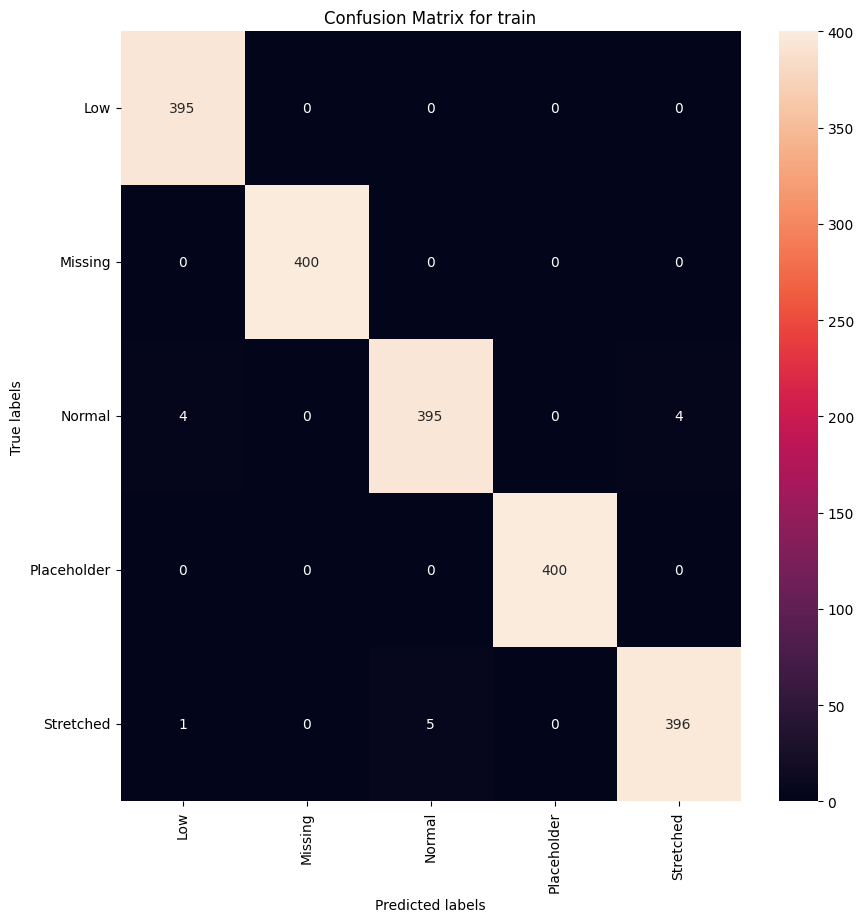

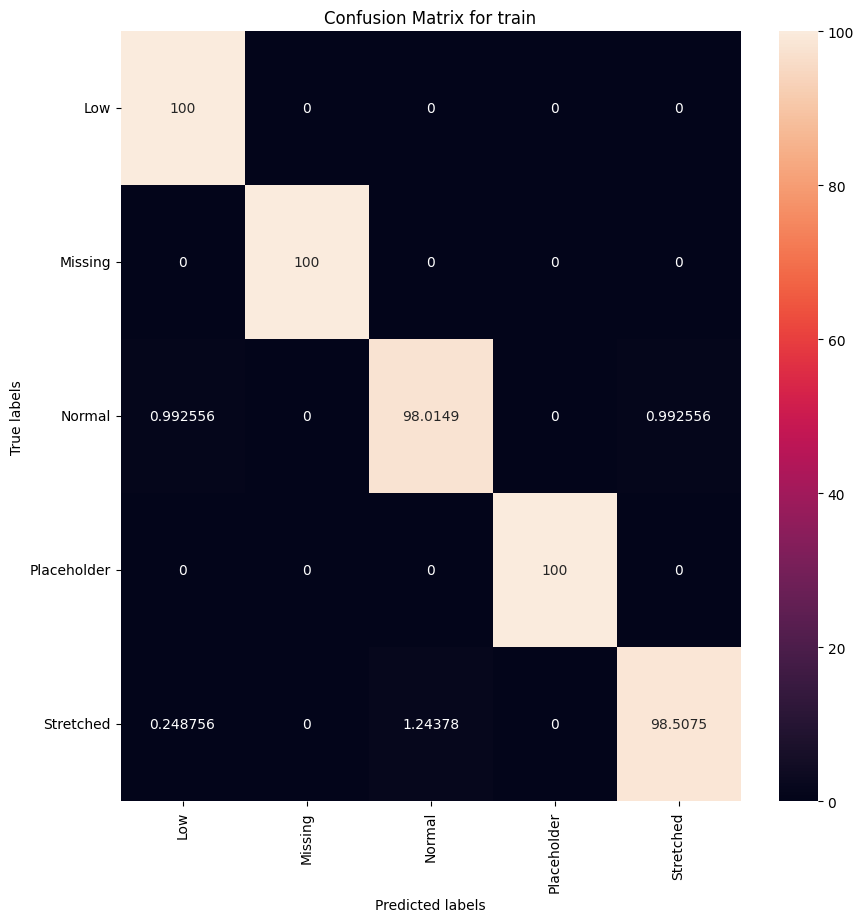

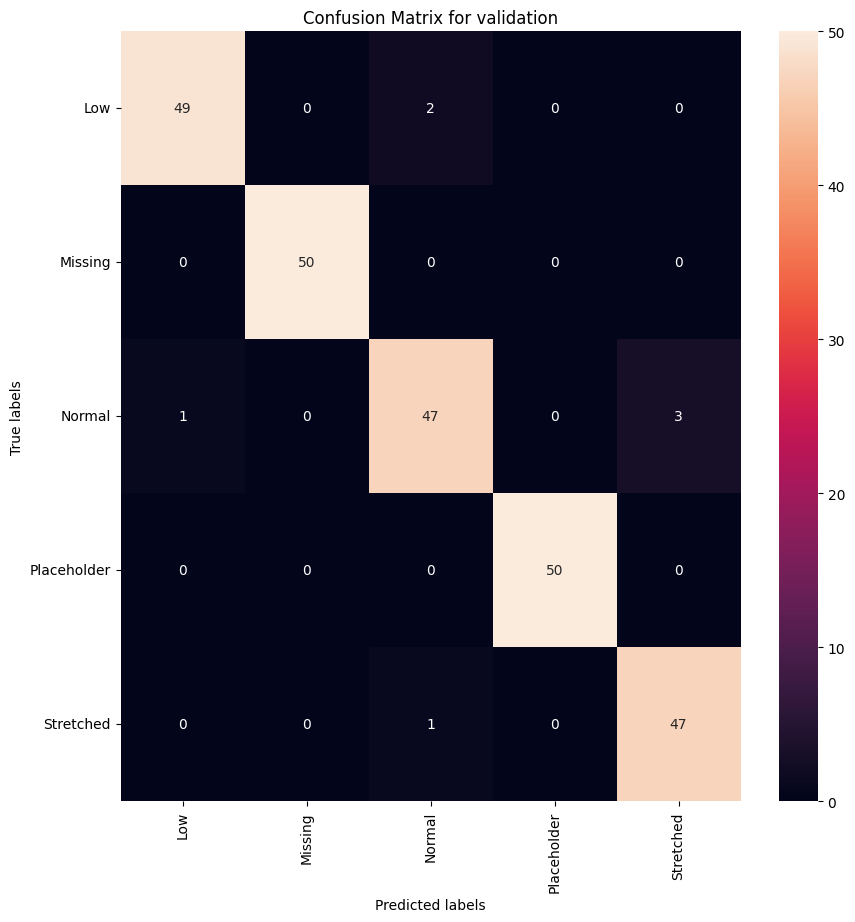

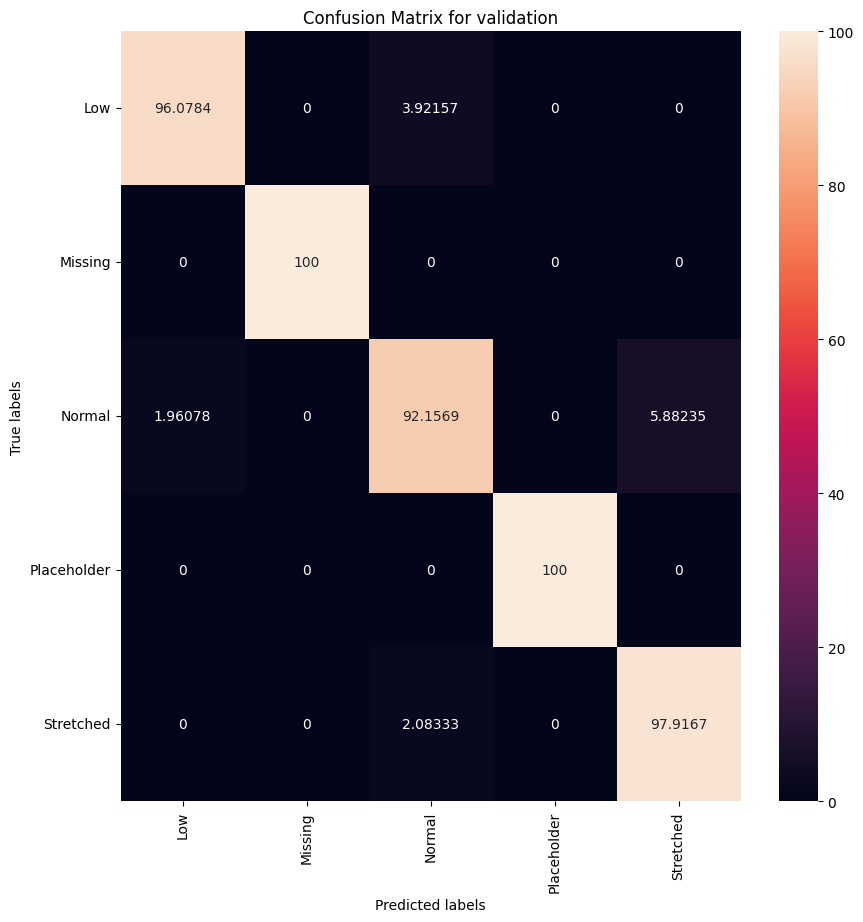

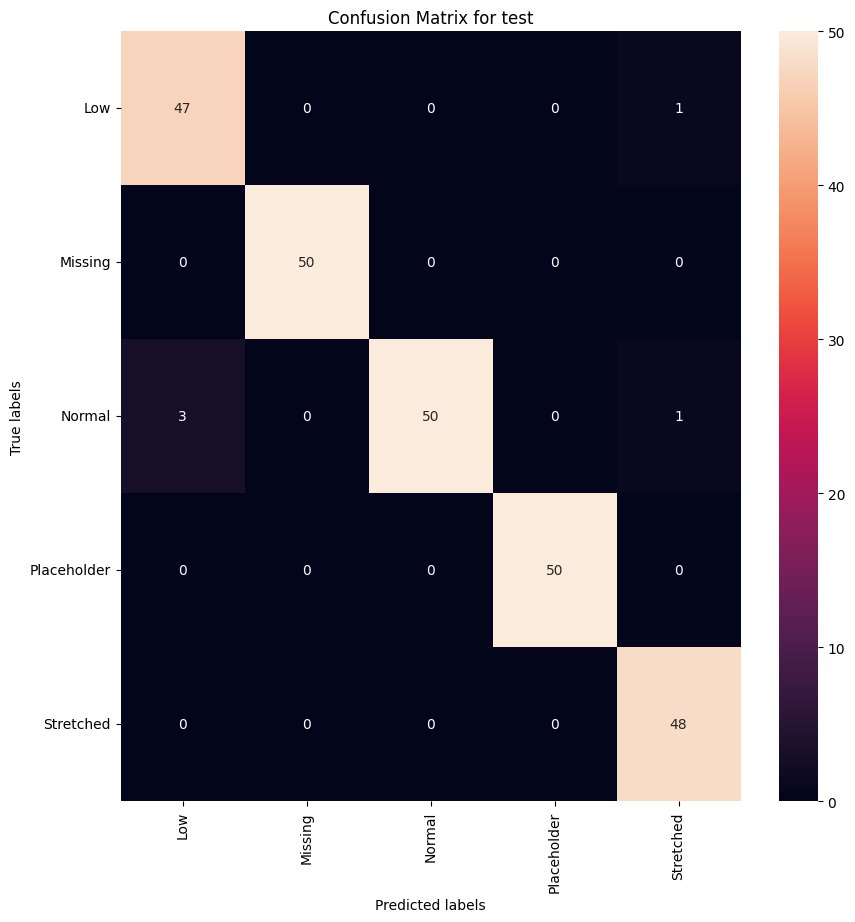

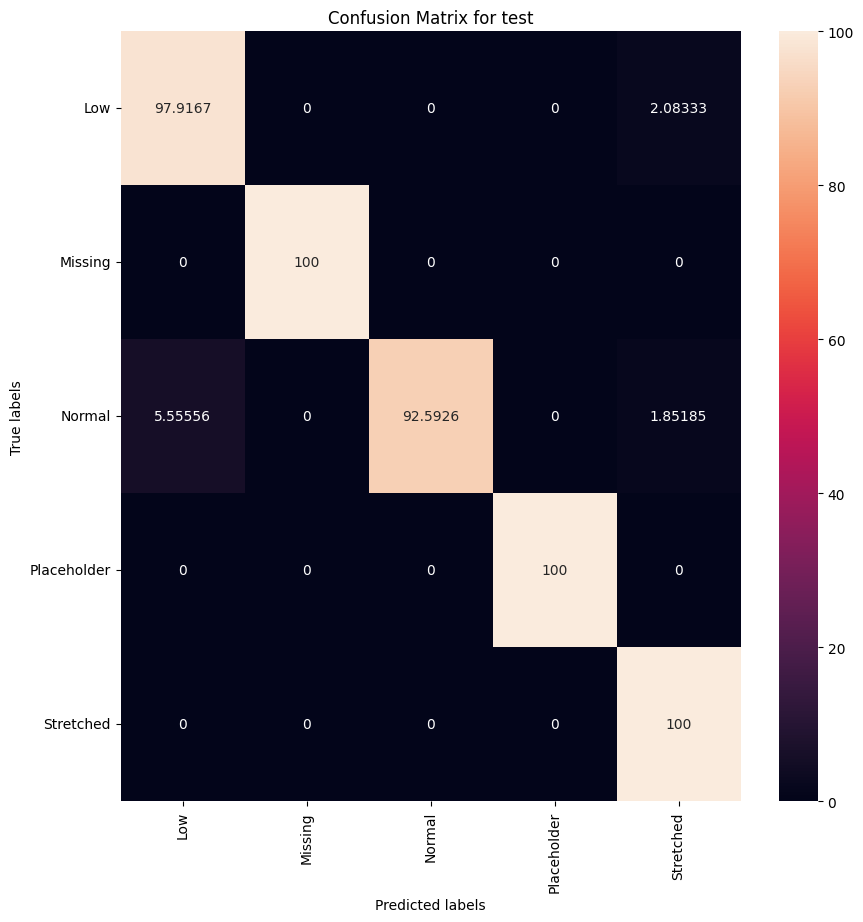

In [32]:
get_cm(train_loader)
get_cm(validation_loader, set_type="validation")
get_cm(test_loader, set_type="test")